<hr>
<div style="background-color: lightgray; padding: 20px; color: black;">
<div>
<img src="https://th.bing.com/th/id/R.3cd1c8dc996c5616cf6e65e20b6bf586?rik=09aaLyk4hfbBiQ&riu=http%3a%2f%2fcidics.uanl.mx%2fwp-content%2fuploads%2f2016%2f09%2fcimat.png&ehk=%2b0brgMUkA2BND22ixwLZheQrrOoYLO3o5cMRqsBOrlY%3d&risl=&pid=ImgRaw&r=0" style="float: right; margin-right: 30px;" width="200"/> 
<font size="6.5" color="8C3061"><b>Regularizaciones TSVD y de Tikhonov </b></font> <br>
<font size="5.5" color="8C3061"><b>Problemas Inversos - Tarea 1 </b></font> 
</div>
<div style="text-align: left">  <br>
Edison David Serrano Cárdenas. <br>
MSc en Matemáticas Aplicadas <br>
CIMAT - Sede Guanajuato <br>
</div>

</div>
<hr>


Haz la discretización del problema de deconvolución de acuerdo al libro de Vogel. El problema inverso consiste en estimar $f_{\text {true }}(x)$ dadas observaciones ruidosas de $g$.

*Cargar librerias:*

In [1]:
import numpy as np
from scipy.optimize import root_scalar

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

np.random.seed(2024)

## <font color="8C3061" >**Implementación del problema inverso**</font> 

*Aproximación de la convolución:* $K$

In [2]:
def k_n (n):
    u = np.arange(1,n+1)
    gamma = 0.025
    c = 1/(np.sqrt(gamma**2*2*np.pi))
    h = 1/n
    return c*h*np.exp((-1/(2*gamma**2))*np.power(h*np.subtract.outer(u,u),2))

*Función fuente:* $f_{true}$

In [3]:
# The implementation is based on vectorized operations
def f_true(x):
    x = np.asarray(x)  # Ensure x is a NumPy array for vectorized operations
    result = np.where((0.1 < x) & (x < 0.25), 0.75,
             np.where((0.3 < x) & (x < 0.32), 0.25,
             np.where((0.5 < x) & (x < 1), np.sin(2 * np.pi * x)**4, 0)))
    return result
    

*Imagen borrosa:*

In [4]:
def g_n(n):
    return k_n(n) @ f_true(np.linspace(0,1,n))

*Datos generados:*

In [5]:
def data_n(n, sigma, eta = False):
    if eta:
        eta = np.random.multivariate_normal(np.zeros(n),sigma**2*np.eye(n))
        return g_n(n) + eta, np.linalg.norm(eta)
    else:
        return g_n(n) + np.random.multivariate_normal(np.zeros(n),sigma**2*np.eye(n))

*Regularización de tikhonov y de TSVD:*

In [6]:
def regularizations(n, alpha, data):
    K = k_n(n)
    u, s, vh = np.linalg.svd(K, full_matrices=False)

    tikhonov = vh.T @ np.diag(s / (s**2 + alpha**2)) @ u.T @ data
    tsvd = vh.T @ np.diag(np.where(s**2 > alpha, s / (s**2), 0)) @ u.T @ data
    return tikhonov, tsvd

In [7]:
def reg(n,alpha,data):
    K = k_n(n)
    u, s, vh = np.linalg.svd(K, full_matrices=False)
    
    tikhonov = vh.T @ np.diag(s / (s**2 + alpha[0]**2)) @ u.T @ data
    tsvd = vh.T @ np.diag(np.where(s**2 > alpha[1], s / (s**2), 0)) @ u.T @ data
    return tikhonov, tsvd   

## <font color="8C3061" >**Generación de los datos**</font> 

Cálculo de $\max_{0\leq x\leq 1} g_n(x)$:

In [8]:
n_sim = np.array([50,100])
max_val = np.array([])
snr = np.array([10,20,100])
for m in n_sim:
    s = g_n(m).max()
    print("Max of g_", m, " is \t", np.round(s,4))
    max_val = np.append(max_val, s)

Max of g_ 50  is 	 0.9499
Max of g_ 100  is 	 0.9522


*Cálculo de $\sigma_\text{noise}$ :*

In [9]:
sigma_noise = np.outer(max_val,1/snr)
display(sigma_noise)

array([[0.09499229, 0.04749615, 0.00949923],
       [0.09522013, 0.04761007, 0.00952201]])

*Cálculo de los datos con ruido:*

In [10]:
data_50 = [data_n(50, sigma,eta=True) for sigma in sigma_noise[0]]
data_100 = [data_n(100, sigma,eta=True) for sigma in sigma_noise[1]]

In [11]:
print("Ruido en 50 datos")
print(round(data_50[0][1],5), round(data_50[1][1],5), round(data_50[2][1],5))
print("Ruido en 100 datos")
print(round(data_100[0][1],5), round(data_100[1][1],5), round(data_100[2][1],5))

Ruido en 50 datos
0.64378 0.34559 0.06789
Ruido en 100 datos
0.9826 0.50471 0.10564


## <font color="8C3061" >**Visualización de los datos**</font> 

Visualización de los datos con y sin ruido:

In [12]:
def plot_data(n, data):
    g = g_n(n)
    z= np.linspace(0,1,400)
    x = np.linspace(0, 1, n)
    plt.figure(figsize=(9, 4))
    plt.plot(z, f_true(z), label='$f_{true}$',color ='#497D74')
    plt.plot(x, g,'--',label='$g_n$ (data)',color ='#B1C29E')
    plt.plot(x, data, 'o', mfc='none', label='$d_n$ noisy data', mec='black', ms=3.5)
    
    plt.ylim(-0.2, 1.2)
    plt.legend(fontsize=9)
    plt.show()

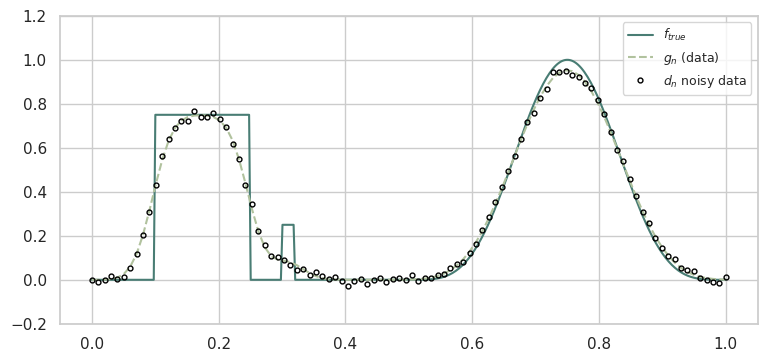

In [13]:
plot_data(n=100, data=data_100[2][0])

## <font color="8C3061" >**Elección del párametro $\alpha$:**</font> 

*Cálculo del error para los modelos:*

In [14]:
def compute_error(data,alpha,n):
    tikhonov, tsvd = regularizations(n, alpha, data)
    err_data_t = np.linalg.norm(data - k_n(n)@tikhonov)
    error_data_tsvd = np.linalg.norm(data - k_n(n)@tsvd)
    
    f_val = f_true(np.linspace(0,1,n))
    
    error_tikhonov = np.linalg.norm(tikhonov - f_val)
    error_tsvd = np.linalg.norm(tsvd - f_val)
    return error_tikhonov, error_tsvd, err_data_t, error_data_tsvd

*Encontrar el valor de $\alpha$ (naive method):*

In [15]:
def select_alpha(data, n,eta):
    alphas = np.linspace(1e-3, 1,250)
    errors = np.array([compute_error(data, alpha, n) for alpha in alphas])
    err_img = np.argmin(np.abs(errors[:,2:]-eta), axis=0)
    
    return alphas[err_img[0]], alphas[err_img[1]]

*Encontrar el valor de $\alpha$ (Find root method):*

In [ ]:
def select_alpha_root_method(data, n, eta):
    def fun(alpha):
        return compute_error(data, alpha, n)[2] - eta
    
    def fun2(alpha):
        return compute_error(data, alpha, n)[3] - eta
    
    return root_scalar(fun, bracket=[1e-3, 1]).root, root_scalar(fun2, bracket=[1e-3, 1]).root

*Visualización de los errores:*

In [16]:
def plot_errors(data, eta, n,save=False,name = None):
    alpha = np.linspace(1e-3, 1,250)
    errors = np.array([compute_error(data, a, n) for a in alpha])
    min_alpha = np.argmin(errors, axis=0)
    
    errors_img = np.argmin(np.abs(errors[:,2:]-eta), axis=0)
    
    
    plt.figure(figsize=(6, 4))
    
    plt.plot(alpha, errors[:,0], label='Tikhonov',color ='#497D74')
    plt.plot(alpha, errors[:,1], label='TSVD',color ='#B1C29E')
    
    
    plt.scatter(alpha[min_alpha[0]], errors[min_alpha[0],0], color='#497D74', s=18, marker='D')
    plt.scatter(alpha[min_alpha[1]], errors[min_alpha[1],1], color='#B1C29E', s=18, marker='D')
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\|f_\alpha-f_{\text{true}}\|$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=9)
    
    if save:
        plt.savefig(name+'.pdf', bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(alpha, errors[:,2], label='Tikhonov',color ='#497D74')
    plt.plot(alpha, errors[:,3], label='TSVD',color ='#B1C29E')
    
    plt.axhline(eta, color='black', linestyle='--', label=r'$\| \eta \|$', alpha=0.5)
    
    plt.scatter(alpha[errors_img[0]], errors[errors_img[0],2], color='#497D74', s=18, marker='8')
    plt.scatter(alpha[errors_img[1]], errors[errors_img[1],3], color='#B1C29E', s=18, marker='8')
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\|Kf_\alpha-d_n\|$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=9)
    
    if save:
        plt.savefig(name+'_Morozov.pdf', bbox_inches='tight')
    

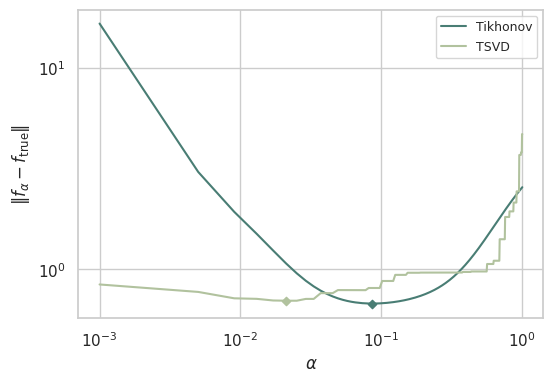

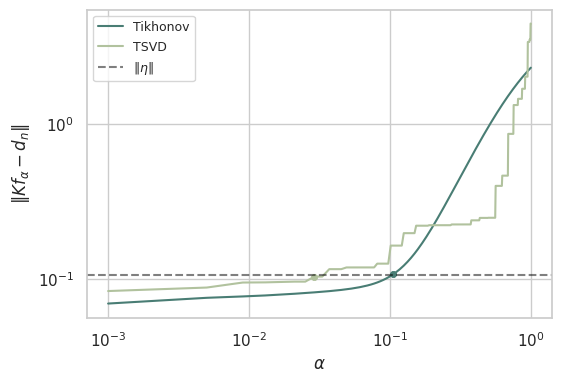

In [17]:
plot_errors(data_100[2][0], data_100[2][1], 100,save=True,name='error_100_sns_100')

*Encontrar los diferente valores para $\alpha$:*

In [19]:
alpha_50 = np.array([select_alpha(data[0], 50, data[1]) for data in data_50]).T
alpha_100 = np.array([select_alpha(data[0], 100, data[1]) for data in data_100]).T

In [43]:
alpha_50_root = np.array([select_alpha_root_method(data[0], 50, data[1]) for data in data_50]).T
alpha_100_root = np.array([select_alpha_root_method(data[0], 100, data[1]) for data in data_100]).T

*Visualización de la regularización para un mallado de $n=100$:*

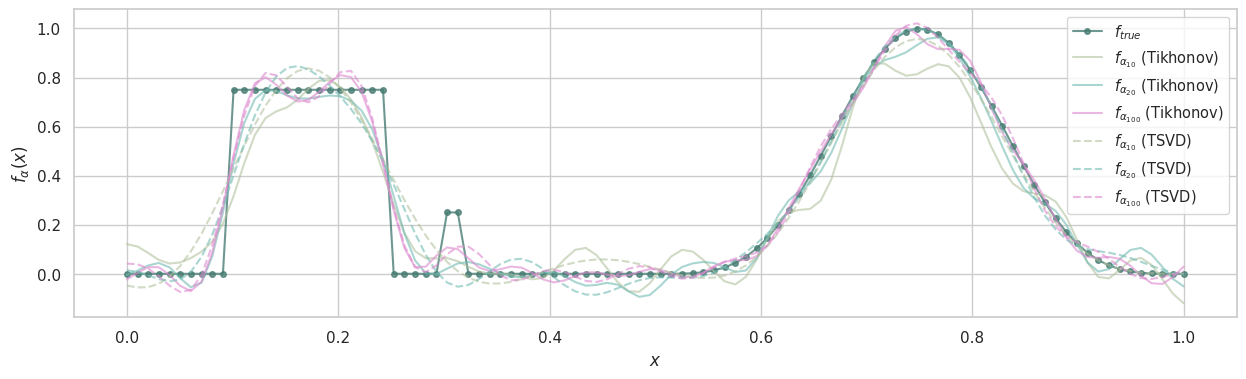

In [78]:
xx = np.linspace(0,1,100)

# N=100
reg_100_10 = reg(n = 100, alpha = alpha_100_root[:,0], data = data_100[0][0])
reg_100_20 = reg(n = 100, alpha = alpha_100_root[:,1], data = data_100[1][0])
reg_100_100 = reg(n = 100, alpha = alpha_100_root[:,2], data = data_100[2][0])


plt.figure(figsize=(15, 4))

plt.plot(xx, f_true(xx), label='$f_{true}$',color ='#497D74',marker='o',markersize=4,alpha = 0.8)
plt.plot(xx, reg_100_10[0], label=r'$f_{\alpha_{10}}$ (Tikhonov)',  color ='#B1C29E', alpha=0.6)
plt.plot(xx, reg_100_20[0], label=r'$f_{\alpha_{20}}$ (Tikhonov)',  color ='#71BBB2', alpha=0.6)
plt.plot(xx, reg_100_100[0], label=r'$f_{\alpha_{100}}$ (Tikhonov)',color ='#DD88CF', alpha=0.6)

plt.plot(xx, reg_100_10[1], '--', label=r'$f_{\alpha_{10}}$ (TSVD)',    color ='#B1C29E', alpha=0.6)
plt.plot(xx, reg_100_20[1], '--', label=r'$f_{\alpha_{20}}$ (TSVD)',    color ='#71BBB2', alpha=0.6)
plt.plot(xx, reg_100_100[1], '--', label=r'$f_{\alpha_{100}}$ (TSVD)',  color ='#DD88CF', alpha=0.6)

plt.legend(fontsize=10.5)
plt.ylabel(r'$f_\alpha(x)$')
plt.xlabel(r'$x$')
plt.savefig('reg_100_f_root.pdf', bbox_inches='tight')
plt.show()

*Visualización de la regularización para un mallado de $n=100$:*

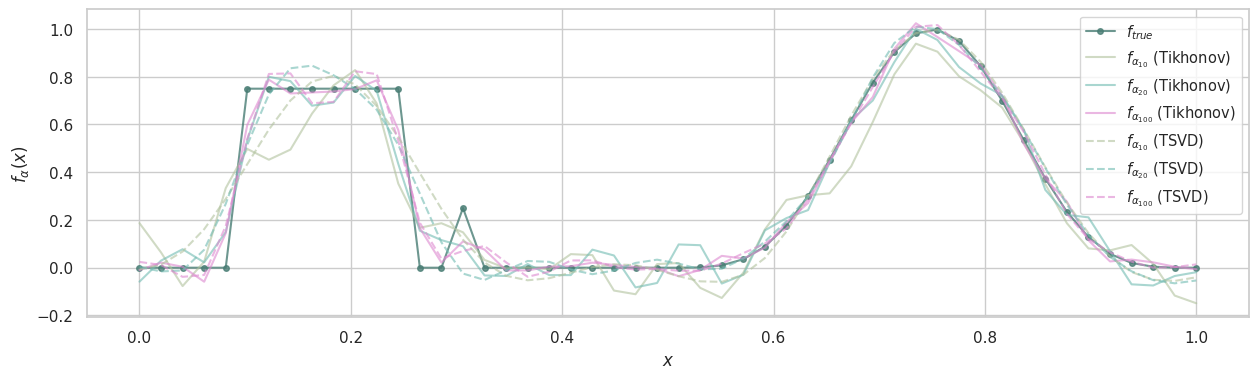

In [80]:
xx = np.linspace(0,1,50)

# N=50
reg_50_10 = reg(n = 50, alpha = alpha_50_root[:,0], data = data_50[0][0])
reg_50_20 = reg(n = 50, alpha = alpha_50_root[:,1], data = data_50[1][0])
reg_50_100 = reg(n = 50, alpha = alpha_50_root[:,2], data = data_50[2][0])

plt.figure(figsize=(15, 4))

plt.plot(xx, f_true(xx), label='$f_{true}$',color ='#497D74', marker='o', markersize=4,alpha=0.8)
plt.plot(xx, reg_50_10[0], label=r'$f_{\alpha_{10}}$ (Tikhonov)',   color ='#B1C29E', alpha=0.6)
plt.plot(xx, reg_50_20[0], label=r'$f_{\alpha_{20}}$ (Tikhonov)',   color ='#71BBB2', alpha=0.6)
plt.plot(xx, reg_50_100[0], label=r'$f_{\alpha_{100}}$ (Tikhonov)', color ='#DD88CF', alpha=0.6)

plt.plot(xx, reg_50_10[1], '--', label=r'$f_{\alpha_{10}}$ (TSVD)',     color ='#B1C29E', alpha=0.6)
plt.plot(xx, reg_50_20[1], '--', label=r'$f_{\alpha_{20}}$ (TSVD)',     color ='#71BBB2', alpha=0.6)
plt.plot(xx, reg_50_100[1], '--', label=r'$f_{\alpha_{100}}$ (TSVD)',   color ='#DD88CF', alpha=0.6)

plt.legend(fontsize=10.5)
plt.ylabel(r'$f_\alpha(x)$')
plt.xlabel(r'$x$')
plt.savefig('reg_50_f_root.pdf', bbox_inches='tight')
plt.show()
